### This notebook has the training colormap plots that show spectral information

8/21

Imports

In [1]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.optim as optim
import heapq
import os
from datetime import datetime
import argparse
import torch.nn.functional as F
from matplotlib.colors import LogNorm

Set save to True if you want to save plots

In [2]:
save = True

Only for python script: uncomment if running on cluster

In [3]:
# These are both placeholders
num_epochs = 1000
model_name = 'f0'

In [4]:
# # Parse command-line arguments
# parser = argparse.ArgumentParser(description='Train a neural network model')
# parser.add_argument('--epochs', type=int, default=1000, help='Number of training epochs')
# parser.add_argument('--model_name', type=str, default='model', help='Name of the saved model')
# args = parser.parse_args()

# # Use the parsed arguments
# num_epochs = args.epochs
# model_name = args.model_name

Check if CUDA is available

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [6]:
# For reproducibility
seed = 42

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(seed)

**Simplified function generation**

In [7]:
def generate_freq_dataset(num_samples, num_points, min_freq, max_freq):
    x = torch.linspace(0, 2 * np.pi, num_points, requires_grad=True)
    functions = []
    derivatives = []
    
    for _ in range(num_samples):
        # The number of different frequency components will be between 1 and 10
        num_freqs = torch.randint(1, 10, (1,)).item()
        amplitudes = torch.rand(num_freqs * 2)  # Double the number of amplitudes (between 0 and 1)
        frequencies = torch.randint(min_freq, max_freq + 1, (num_freqs,)).float()
        phases = torch.rand(num_freqs * 2) * 2 * np.pi  # Double the number of phases
        
        y = sum(a * torch.sin(f * x + p) for a, f, p in zip(amplitudes[:num_freqs], frequencies, phases[:num_freqs])) + \
            sum(a * torch.cos(f * x + p) for a, f, p in zip(amplitudes[num_freqs:], frequencies, phases[num_freqs:]))
        
        dy_dx = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
        
        functions.append(y.detach().numpy())
        derivatives.append(dy_dx.detach().numpy())
    
    return np.array(functions), np.array(derivatives)

## Generate datasets

In [8]:
num_samples = 500
num_points = 1000
batch_size = 32

low_freq_functions, low_freq_derivatives = generate_freq_dataset(num_samples, num_points, 1, 5)
general_freq_functions, general_freq_derivatives = generate_freq_dataset(num_samples, num_points, 1, 10)
high_freq_functions, high_freq_derivatives = generate_freq_dataset(num_samples, num_points, 6, 10)

low_freq_dataset = TensorDataset(torch.tensor(low_freq_functions), torch.tensor(low_freq_derivatives))
general_freq_dataset = TensorDataset(torch.tensor(general_freq_functions), torch.tensor(general_freq_derivatives))
high_freq_dataset = TensorDataset(torch.tensor(high_freq_functions), torch.tensor(high_freq_derivatives))

low_freq_dataloader = DataLoader(TensorDataset(torch.tensor(low_freq_functions), torch.tensor(low_freq_derivatives)), batch_size=batch_size, shuffle=True)
high_freq_dataloader = DataLoader(TensorDataset(torch.tensor(high_freq_functions), torch.tensor(high_freq_derivatives)), batch_size=batch_size, shuffle=True)
general_freq_dataloader = DataLoader(TensorDataset(torch.tensor(general_freq_functions), torch.tensor(general_freq_derivatives)), batch_size=batch_size, shuffle=True)

In [9]:
total_size = len(low_freq_dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size
generator = torch.Generator().manual_seed(seed)

# low freq
train_dataset_l, test_dataset_l = random_split(low_freq_dataset, [train_size, test_size], generator=generator)
train_dataloader_l = DataLoader(train_dataset_l, batch_size=32, shuffle=True, drop_last=True)
test_dataloader_l = DataLoader(test_dataset_l, batch_size=32, shuffle=False, drop_last=True)

# general freq
train_dataset_g, test_dataset_g = random_split(general_freq_dataset, [train_size, test_size], generator=generator)
train_dataloader_g = DataLoader(train_dataset_g, batch_size=32, shuffle=True, drop_last=True)
test_dataloader_g = DataLoader(test_dataset_g, batch_size=32, shuffle=False, drop_last=True)

# high freq
train_dataset_h, test_dataset_h = random_split(high_freq_dataset, [train_size, test_size], generator=generator)
train_dataloader_h = DataLoader(train_dataset_h, batch_size=32, shuffle=True, drop_last=True)
test_dataloader_h = DataLoader(test_dataset_h, batch_size=32, shuffle=False, drop_last=True)


## Plot random function from one of the datasets

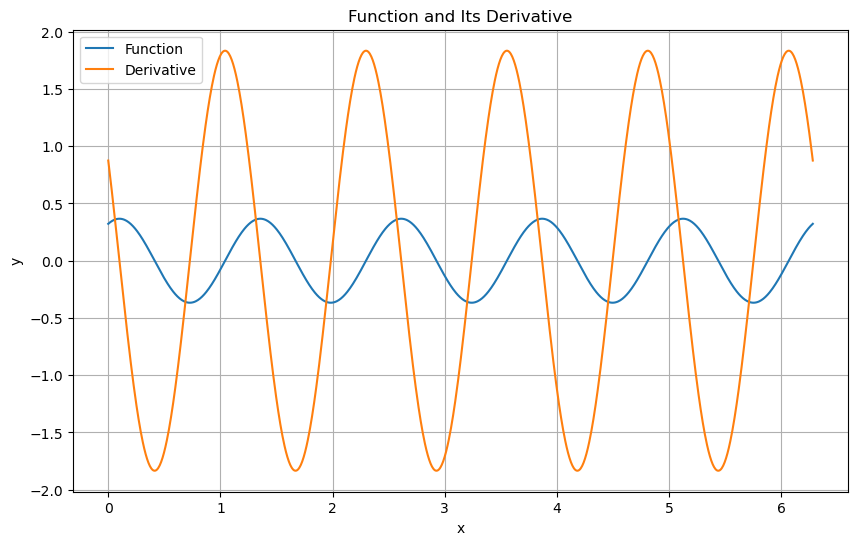

In [10]:
a = np.random.randint(32)

fun, deriv = next(iter(low_freq_dataloader))

first_function = fun[a]
first_derivative = deriv[a]

# Generate x values corresponding to the function inputs
x_values = np.linspace(0, 2 * np.pi, 1000)

# Plotting the function and its derivative
plt.figure(figsize=(10, 6))
plt.plot(x_values, first_function, label='Function')
plt.plot(x_values, first_derivative, label='Derivative')
plt.title('Function and Its Derivative')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Save datasets
# torch.save(general_freq_dataset, 'datasets/general_freq_dataset.pt')
# torch.save(low_freq_dataset, 'datasets/low_freq_dataset.pt')
# torch.save(high_freq_dataset, 'datasets/high_freq_dataset.pt')

Stopped here

## Model architecture

This CNN uses 3 layers, each with kernel size 3

In [12]:
# simple 1D CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(64, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [13]:
f0 = SimpleCNN()
criterion = nn.MSELoss()

## Miscellaneous plotting functions

In [14]:
def plot_losses(train_losses, test_losses, save_dir='plots', filename=None, save=False):
    if not train_losses:
        return
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    current_date = datetime.now().strftime("%m-%d")
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, linestyle='-', color='b', label='Training Loss')
    plt.plot(epochs, test_losses, linestyle='-', label='Test Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')  # Set the y-axis to logarithmic scale
    plt.legend()
    plt.grid(True)
    filename = f"{filename}_{current_date}.png"
    save_path = os.path.join(save_dir, filename)
    if save:
        plt.savefig(save_path)    
    plt.show()

In [15]:
def plot_output(model1, dataset, order=None, save_dir='plots', filename=None, save=False): 
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    current_date = datetime.now().strftime("%m-%d")
    model1.eval()  # Set the model to evaluation mode

    train_dataloader_viz = get_random_function(dataset, shuffle=True)
    # Get a random sample from the dataloader
    dataiter = iter(train_dataloader_viz)
    function, true_derivative = next(dataiter)

    # Reshape the input for the model
    function = function.unsqueeze(1)  # Add channel dimension

    # Make prediction
    with torch.no_grad():
        if order == 1 or order == 2:
            predicted_derivative = model1(function)
        
        if order == 'rollout':
            predicted_derivative = model1(function)
            predicted_derivative = model1(predicted_derivative)

    # Convert tensors to numpy arrays for plotting
    x = torch.linspace(0, 2*torch.pi, 1000).numpy()
    function = function.squeeze().numpy()

    predicted_derivative = predicted_derivative.squeeze().numpy()

    true_derivative = true_derivative.squeeze().numpy()

    # Plot the results
    plt.figure(figsize=(12, 6))

    plt.plot(x, function, label='Original Function', color='blue')
    if order == 1:
        plt.plot(x, true_derivative, label=f'True {order}st derivative')

    plt.plot(x[10:-10], predicted_derivative[10:-10], label=f'Predicted {order}nd Derivative', linestyle='--')

    plt.title('Function, True Derivatives, and Predicted Derivatives')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    filename = f"{filename}_{current_date}.png"

    save_path = os.path.join(save_dir, filename)
    if save:
        plt.savefig(save_path)  
    plt.show()

In [16]:
def get_random_function(dataset, shuffle=True):
    return DataLoader(dataset, batch_size=1, shuffle=shuffle)

## Create models

In [17]:
# simple 1D CNN
class SimpleCNN(nn.Module):
    def __init__(self, n_layers=3, kernel_size=3, hidden_size=64):
        super(SimpleCNN, self).__init__()
        # Parameters
        self.n_layers = n_layers
        self.kernel_size = kernel_size
        self.hidden_size = hidden_size

        # Model
        self.convs = nn.ModuleList()
        if n_layers == 1:
            self.convs.append(nn.Conv1d(1, 1, kernel_size=kernel_size, padding=kernel_size//2))
        elif n_layers >= 2:
            self.convs.append(nn.Conv1d(1, hidden_size, kernel_size=kernel_size, padding=kernel_size//2))
            for _ in range(n_layers - 2):
                self.convs.append(nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_size, padding=kernel_size//2))
            self.convs.append(nn.Conv1d(hidden_size, 1, kernel_size=kernel_size, padding=kernel_size//2))
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        for i, conv in enumerate(self.convs):
            if i < len(self.convs) - 1:
                x = self.relu(conv(x))
            else:
                x = conv(x)
        return x

## Tests to see model output frequencies

In [36]:
def plot_frequencies(function, derivative=None, residue=None, model=None):
    x = np.linspace(0, 2*np.pi, 1000)
    first_function = function

    N = 1000

    # frequencies = torch.fft.fftfreq(N, 2*np.pi/N) * 2*np.pi
    frequencies = np.fft.fftfreq(N, 1/N)
    positive_freq_indices = frequencies >= 0
    positive_freqs = frequencies[positive_freq_indices]

    F = np.fft.fft(first_function.detach().numpy())
    magnitudes = np.abs(F) / N
    positive_magnitudes = magnitudes[positive_freq_indices]

    if residue:
        model.eval()
        F_derivative = np.fft.fft(derivative.detach().numpy())
        F_output = np.fft.fft(model(function.unsqueeze(0)).squeeze().detach().numpy())

        F_residue = F_derivative - F_output
        magnitudes = np.abs(F_residue) / N
        print("residue")


    # Plotting the frequency spectrum
    plt.figure(figsize=(10, 6))
    plt.plot(positive_freqs, positive_magnitudes, label='Function')
    plt.xlabel('Frequency')
    plt.ylabel('Magnitude')
    plt.title('Frequency Spectrum of the Function')
    plt.legend()
    plt.grid(True)
    plt.xlim(0, 20)  # Adjust this based on your frequency range
    print(f"lim: 18")
    plt.show()


In [75]:
def plot_frequencies(function, derivative=None, residue=None, model=None):
    x = np.linspace(0, 2*np.pi, 1000)
    first_function = function

    N = 1000

    # frequencies = torch.fft.fftfreq(N, 2*np.pi/N) * 2*np.pi
    frequencies = np.fft.fftfreq(N, 1/N)
    positive_freq_indices = frequencies >= 0
    positive_freqs = frequencies[positive_freq_indices]

    F = np.fft.fft(first_function.detach().numpy())
    magnitudes = np.abs(F) / N
    positive_magnitudes = magnitudes[positive_freq_indices]

    if residue:
        model.eval()
        F_derivative = np.fft.fft(derivative.detach().numpy())
        F_output = np.fft.fft(model(function.unsqueeze(0)).squeeze().detach().numpy())

        F_residue = F_derivative - F_output
        magnitudes = np.abs(F_residue) / N
        print("residue")


    # Plotting the frequency spectrum
    plt.figure(figsize=(10, 6))
    # plt.plot(positive_freqs, positive_magnitudes, label='Function')
    plt.stem(positive_freqs, positive_magnitudes, 'b', markerfmt=" ", basefmt="b-", use_line_collection=True, label='Function')
    plt.xlabel('Frequency')
    plt.ylabel('Magnitude')
    plt.title('Frequency Spectrum of the Function')
    plt.legend()
    plt.grid(True)
    plt.xlim(0, 12.5)  # Adjust this based on your frequency range
    print(f"lim: 18")
    plt.show()

lim: 18


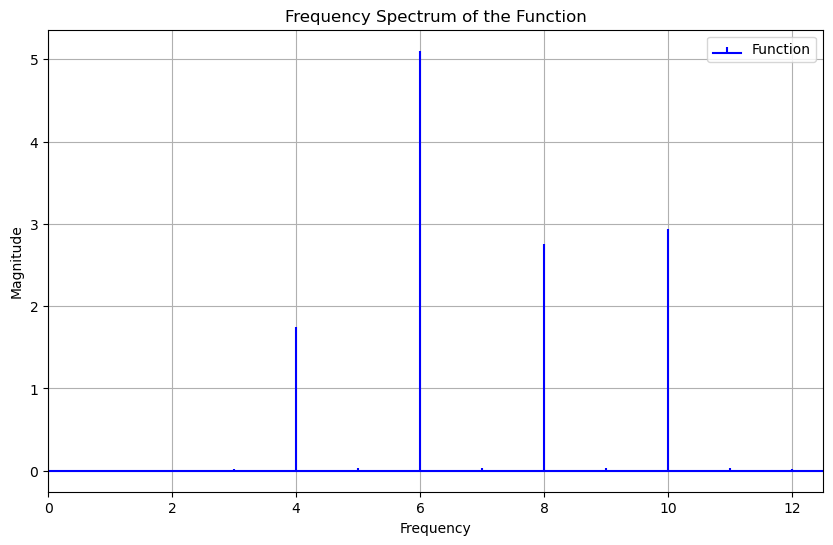

In [76]:
# a = np.random.randint(0, 32)
a = 8
function = test_dataset_g[a][0]
derivative = test_dataset_g[a][1]

plot_frequencies(derivative)

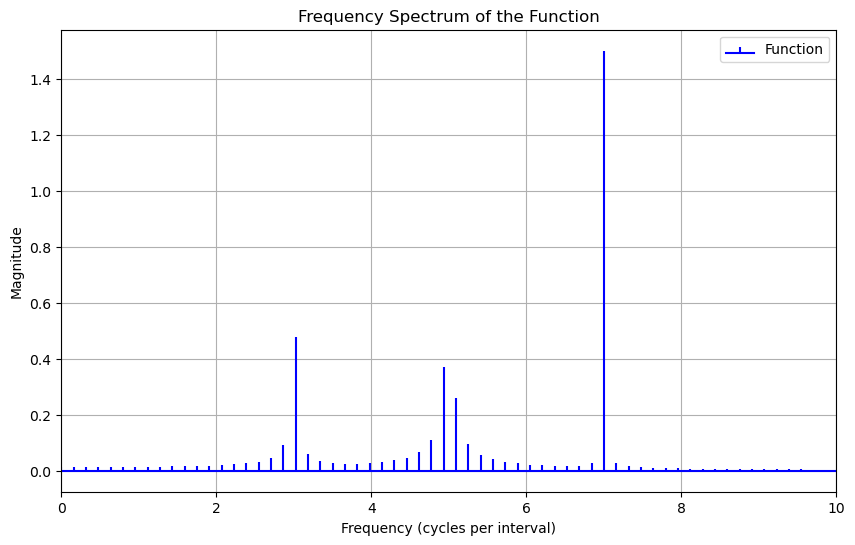

In [77]:
def plot_frequencies_test(function):
    N = 1000  # Number of samples
    x = np.linspace(0, 2 * np.pi, N, endpoint=False)  # Sample points
    y = function(x)  # Evaluate function

    # Compute DFT
    F = np.fft.fft(y)
    frequencies = np.fft.fftfreq(N, d=2*np.pi/N)
    # frequencies = np.fft.fftfreq(N, d=2*np.pi/N)*2*np.pi
    magnitudes = np.abs(F) / N

    # Filter for positive frequencies
    positive_freq_indices = frequencies >= 0
    positive_freqs = frequencies[positive_freq_indices]
    positive_magnitudes = magnitudes[positive_freq_indices]

    # Plotting the frequency spectrum
    plt.figure(figsize=(10, 6))
    plt.stem(positive_freqs, positive_magnitudes, 'b', markerfmt=" ", basefmt="b-", use_line_collection=True, label='Function')
    plt.xlabel('Frequency (cycles per interval)')
    plt.ylabel('Magnitude')
    plt.title('Frequency Spectrum of the Function')
    plt.legend()
    plt.grid(True)
    plt.xlim(0, 10)  # Adjust this to a little above the highest frequency of interest
    plt.show()

# Define the example function
def example_function(x):
    # return np.sin(3*x)+np.sin(5*x)+3*np.sin(7*x)
    return np.sin(3*2*np.pi*x) + np.sin(5*2*np.pi*x) + 3*np.sin(7*2*np.pi*x)

# Plot frequencies
plot_frequencies_test(example_function)

In [78]:
set_seed(seed)
L3ModelK3 = SimpleCNN(n_layers=3, kernel_size=3)
L3ModelK3.load_state_dict(torch.load('../../models/3_layers.pth'))

L3ModelK3_untrained = SimpleCNN(n_layers=3, kernel_size=3)

lim: 18


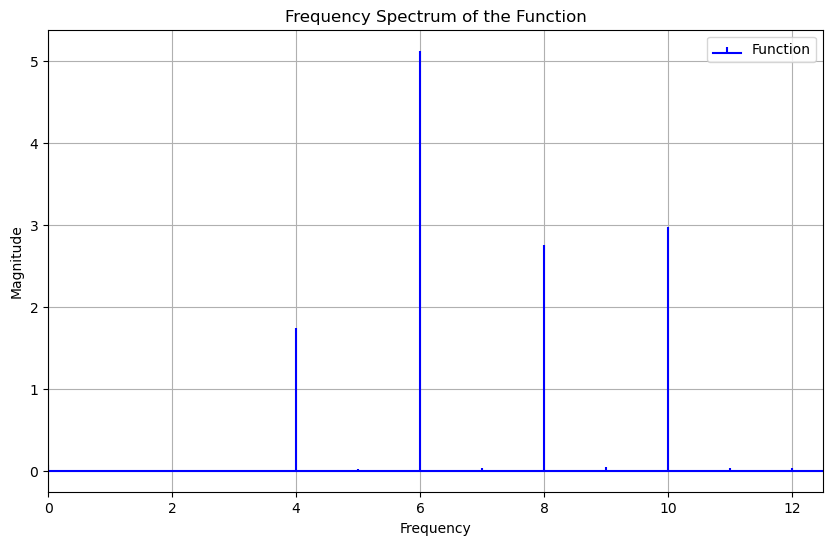

In [79]:
function1 = function.unsqueeze(0)
output = L3ModelK3(function1).squeeze()
plot_frequencies(output)

residue
lim: 18


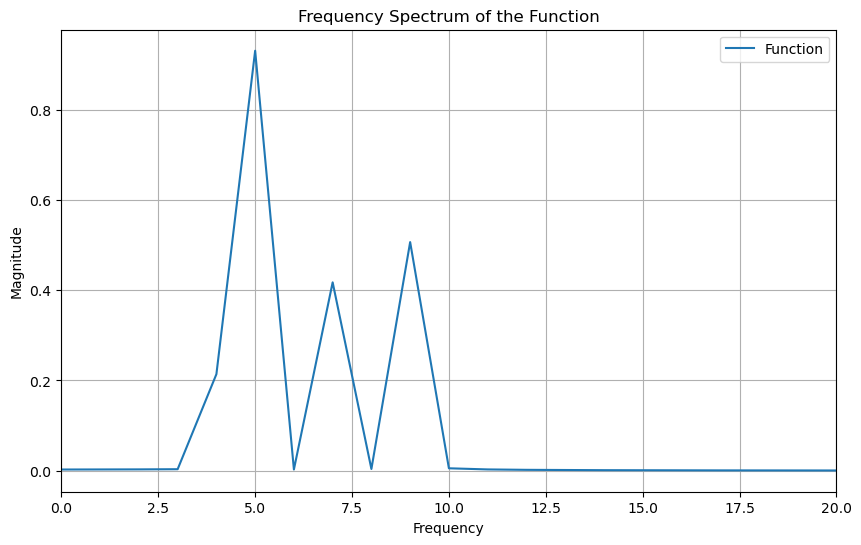

In [22]:
plot_frequencies(function=function, derivative=derivative, residue=True, model=L3ModelK3)

## Metric functions

In [23]:
def compute_mse(dataloader, model):
    """
    Takes in a dataloader and a model to compute MSE.
    """

    model.eval()
    all_outputs = []
    all_targets = []

    for function, deriv in dataloader:
        function = function.unsqueeze(1)
        deriv = deriv.unsqueeze(1)

        # Compute model output
        model_output = model(function)
        all_targets.append(deriv)

        # Collect outputs
        all_outputs.append(model_output)

    # Concatenate all collected outputs and targets
    all_outputs = torch.cat(all_outputs, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # Compute MSE
    mse = torch.mean((all_targets - all_outputs) ** 2)
    nmse = mse / torch.mean(all_targets ** 2)

    return mse.item(), nmse.item()

In [24]:
def print_and_store_metrics(f0):
    return compute_mse(train_dataloader_l, f0)[1], compute_mse(train_dataloader_g, f0)[1], compute_mse(train_dataloader_h, f0)[1]

In [25]:
def print_metrics(model):
    print(f"NMSE over low freq test functions: {compute_mse(test_dataloader_l, model)[1]}")
    print(f"NMSE over general freq test functions: {compute_mse(test_dataloader_g, model)[1]}")
    print(f"NMSE over high freq test functions: {compute_mse(test_dataloader_h, model)[1]}")



## Plot results

In [26]:
def plot_all_outputs(model, model_name):
    plot_output(model, dataset=test_dataset_l, order=1, save_dir='../plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_lf_output', save=save)
    plot_output(model, dataset=test_dataset_g, order=1, save_dir='../plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_lf_output', save=save)
    plot_output(model, dataset=test_dataset_h, order=1, save_dir='../plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_lf_output', save=save)

## Color map plots

In [27]:
def RMS(x):
    return torch.sqrt(torch.mean(x**2, dim=1)).unsqueeze(1)

In [28]:
def compute_fft_and_max_freq(dataloader, deriv=False, model=None, residue=False):
    fft_amplitudes = []
    max_frequencies = []
    T = 2 * torch.pi
    N = 1000

    # The spacing is T / N, i.e. 2pi/1000, but since we interpret f(x)=sin(5x) to
    # have a frequency of 5 over the domain x=[0,2pi], then we scale up by 2pi 
    # to get the unit cycle back to 1
    frequencies = torch.fft.fftfreq(N, T / N) * T
    positive_freq_indices = frequencies >= 0
    positive_freqs = frequencies[positive_freq_indices]

    plot_type = ''

    # Iterate over each batch
    for functions, derivatives in dataloader:  # Note that derivatives are ignored in this loop
        
        if deriv and model and not residue: # If you only want the derivative
            functions = derivatives
            F = torch.fft.fft(functions)
            plot_type = "$u_g'$"
            
            
        elif not deriv and model and not residue: # If you only want the model output
            functions = model(functions.unsqueeze(1)).squeeze()
            F = torch.fft.fft(functions)
            plot_type = '$f(u_g)$'

            # output = model(functions)
            
            # output = output.squeeze()
            # functions = output # set this so that the FFTs can be computed in the next line
        
        elif residue == 'error of fourier' and model: # If you only want the spectral error
            functions = functions.unsqueeze(1)
            outputs = model(functions).squeeze()
            F_outputs = torch.fft.fft(outputs)
            F_derivatives = torch.fft.fft(derivatives)
            residues = F_derivatives - F_outputs
            # F = residues / RMS(F_derivatives)
            F = torch.abs(residues) / torch.abs(F_derivatives)
            plot_type = 'spectral error'

        
        elif residue == 'fourier of error' and model:
            functions = functions.unsqueeze(1)
            outputs = model(functions).squeeze()

            residues = derivatives - outputs
            F = torch.fft.fft(residues)
            plot_type = 'fourier transform of error'

        else:
            plot_type = 'ground truth u_g'
            F = torch.fft.fft(functions)

        # else: # If you only want the original function u_g
        magnitudes = torch.abs(F) / N

        # Consider only positive frequencies
        positive_magnitudes = magnitudes[:, positive_freq_indices]

        fft_amplitudes.append(positive_magnitudes)
        
        # Maximum frequency based on the highest amplitude for each function in the batch
        max_indices = torch.argmax(positive_magnitudes, dim=1)
        batch_max_freqs = positive_freqs[max_indices]
        max_frequencies.extend(batch_max_freqs)
    
    print(f"Plotting {plot_type}")

    return torch.vstack(fft_amplitudes), torch.tensor(max_frequencies), positive_freqs, plot_type

def plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type, xmin=0, xmax=0,\
    first=False, sorted_indices=None):

    fft_amplitudes = fft_amplitudes.detach().numpy()
    max_frequencies = max_frequencies.detach().numpy()
    freqs = freqs.detach().numpy()

    
    if first:
        print("Sorting u_g for the first time")
        # Sort functions by dominant frequency in descending order
        sorted_indices = np.argsort(-max_frequencies) 
        sorted_fft = fft_amplitudes[sorted_indices]
    else:
        print("Using predefined sort")
        sorted_fft = fft_amplitudes[sorted_indices]

    plt.figure(figsize=(10, 6))
    # im = plt.imshow(sorted_fft, aspect='auto', extent=[freqs[0], freqs[-1], 0, len(sorted_fft)],\
    #     interpolation='nearest')
    im = plt.imshow(sorted_fft, aspect='auto', extent=[freqs[0], freqs[-1], 0, len(sorted_fft)],
                     interpolation='nearest', norm = LogNorm(vmin=0.01, vmax=10))

    plt.colorbar(im, label='Amplitude')
    plt.xlabel('Frequency')
    plt.ylabel('Function Index')
    plt.title(f'FFT Amplitude Heatmap of {fun_type}')
    plt.xlim([xmin, xmax])
    

    if first:
        return sorted_indices

    plt.show()


In [29]:
# This function is for showing the side by side of spectral error and model output
def plot_combined_heatmap(fft_amplitudes1, max_frequencies1, freqs1, fun_type1,\
    fft_amplitudes2, max_frequencies2, freqs2, fun_type2,\
    xmin=0, xmax=0, first=False, sorted_indices=None):

    fft_amplitudes1 = fft_amplitudes1.detach().numpy()
    max_frequencies1 = max_frequencies1.detach().numpy()
    freqs1 = freqs1.detach().numpy()

    fft_amplitudes2 = fft_amplitudes2.detach().numpy()
    max_frequencies2 = max_frequencies2.detach().numpy()
    freqs2 = freqs2.detach().numpy()

    
    if first:
        print("Sorting u_g for the first time")
        # Sort functions by dominant frequency in descending order
        sorted_indices1 = np.argsort(-max_frequencies1) 
        sorted_fft1 = fft_amplitudes1[sorted_indices]

        sorted_indices2 = np.argsort(-max_frequencies2) 
        sorted_fft2 = fft_amplitudes2[sorted_indices]
    else:
        print("Using predefined sort")
        sorted_fft1 = fft_amplitudes1[sorted_indices]
        sorted_fft2 = fft_amplitudes2[sorted_indices]

    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

    # Plot the first heatmap
    im1 = ax1.imshow(sorted_fft1, aspect='auto', extent=[freqs1[0], freqs1[-1], 0, len(sorted_fft1)],
                     interpolation='nearest')
    ax1.set_xlabel('Frequency')
    ax1.set_ylabel('Function Index')
    ax1.set_title(f'FFT Amplitude Heatmap of {fun_type1}')
    ax1.set_xlim([xmin, xmax])
    fig.colorbar(im1, ax=ax1, label='Amplitude')

    # Plot the second heatmap
    # im2 = ax2.imshow(sorted_fft2, aspect='auto', extent=[freqs2[0], freqs2[-1], 0, len(sorted_fft2)],
    #                  interpolation='nearest', vmax=0.005)

    im2 = ax2.imshow(sorted_fft2, aspect='auto', extent=[freqs2[0], freqs2[-1], 0, len(sorted_fft2)],
                     interpolation='nearest', norm = LogNorm(vmin=0.01, vmax=10))
    ax2.set_xlabel('Frequency')
    ax2.set_ylabel('Function Index')
    # ax2.set_title(f'FFT Amplitude Heatmap of {fun_type2}')
    ax2.set_title(f'FFT Amplitude Heatmap of {fun_type2}')

    ax2.set_xlim([xmin, xmax])
    fig.colorbar(im2, ax=ax2, label='Amplitude')

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    if first:
        return sorted_indices1

    plt.show()

In [30]:
# Default is u_g
# This function plots the heatmaps for all frequencies for the test datlaoaders
def plot_heatmaps(deriv=None, model=None, residue=False, label=None, all=True, epoch=None,\
    first=False, sorted_indices=None):
    if all: # Plot all three datasets
        fft_amplitudes, max_frequencies, freqs, label = compute_fft_and_max_freq(test_dataloader_l,\
            deriv=deriv, model=model, residue=residue)
        plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type=f'Low freq {label} at Epoch {epoch}',\
            xmin=0, xmax=6, sorted_indices=sorted_indices, first=first)

        fft_amplitudes, max_frequencies, freqs, label = compute_fft_and_max_freq(test_dataloader_g,\
            deriv=deriv, model=model, residue=residue)
        plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type=f'{label} at Epoch {epoch}',\
            xmin=0, xmax=11, sorted_indices=sorted_indices, first=first)

        fft_amplitudes, max_frequencies, freqs, label = compute_fft_and_max_freq(test_dataloader_h,\
            deriv=deriv, model=model, residue=residue)
        plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type=f'High freq {label} at Epoch {epoch}',\
            xmin=6, xmax=11, sorted_indices=sorted_indices, first=first)

    else: # Plot only the general frequency dataset
        if model and residue:
            print("got the new amplitudes")
            # Get only the model outputs
            fft_amplitudes_model, max_frequencies_model, freqs_model, label_model = compute_fft_and_max_freq(test_dataloader_g,\
            deriv=deriv, model=model, residue=None)
            # Get only the residue
            fft_amplitudes_res, max_frequencies_res, freqs_res, label_res = compute_fft_and_max_freq(test_dataloader_g,\
            deriv=deriv, model=model, residue=residue)
        else: # If we don't want the model or residue plots, then use passed in settings
            fft_amplitudes, max_frequencies, freqs, label = compute_fft_and_max_freq(test_dataloader_g,\
            deriv=deriv, model=model, residue=residue)

        if first: # If first calculation, then need to only get the order of the original functions u_g
            fft_amplitudes, max_frequencies, freqs, label = compute_fft_and_max_freq(test_dataloader_g,\
            deriv=False, model=False, residue=False)
            return plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type=f'{label} at Epoch {epoch}',\
            xmin=0, xmax=11, sorted_indices=sorted_indices, first=first)
        else:
            if model and residue:
                # plot_heatmap(fft_amplitudes_model, max_frequencies_model, freqs_model, fun_type=f'General freq {label_model} at Epoch {epoch}',\
                # xmin=0, xmax=11, sorted_indices=sorted_indices, first=first)

                plot_combined_heatmap(fft_amplitudes1=fft_amplitudes_model, max_frequencies1=max_frequencies_model,\
                    freqs1=freqs_model, fun_type1=f'General freq {label_model} at Epoch {epoch}',\
                    fft_amplitudes2=fft_amplitudes_res, max_frequencies2=max_frequencies_res,\
                    freqs2=freqs_res, fun_type2=f'General freq {label_res} at Epoch {epoch}',\
                    xmin=0, xmax=11, sorted_indices=sorted_indices, first=first)

            else:
                plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type=f'{label} at Epoch {epoch}',\
                xmin=0, xmax=11, sorted_indices=sorted_indices, first=first)


In [31]:
train_losses, test_losses = [], []

def model_training_plots(model, train_dataloader, test_dataloader, num_epochs,\
    split_freq=1, filename=None, save=None, order=None, nmse=False,\
        deriv=None, residue=None, lr=1e-3, heatmap=True):

    """
    model: provide a model to train
    train/test_dataloader: provide a specific dataloader 
    num_epochs: train for this many epochs
    split_freq: really should be called "number of colormaps to show"
    filename: filename to save final loss vs iterations plot as
    save: whether to save the file
    order: not sure this even matters
    nmse: set to True to use NMSE as loss function during training
    deriv: set to True to show derivative
    residue: set to 1 to show spectral error, i.e., hat(u_g') - hat(f(u_g)),
        and set to 2 to show fourier transform of error, i.e., hat(u_g' - f(u_g))
    


    """

    train_losses = []
    test_losses = []

    low_freq_nmses = []
    general_freq_nmses = []
    high_freq_nmses = []
    epoch_list = []

    lr = lr
    optimizer = optim.Adam(model.parameters(), lr=lr)

    criterion = nn.MSELoss()
    # If nmse, then use NMSE as loss
    if nmse:
        def criterion(target, output, nmse=None):
            mse = torch.mean((target - output) ** 2)
            mse = mse / torch.mean(target ** 2)
            
            return mse
    
    num_plots = split_freq
    split_freq = num_epochs // split_freq
    print(split_freq)

    # At the first epoch, compute the order of the functions before training
    sorted_indices = plot_heatmaps(label=f'first', all=False, first=True)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        test_loss = 0.0

        for batch_functions, batch_derivatives in train_dataloader:
            batch_functions = batch_functions.unsqueeze(1)
            batch_derivatives = batch_derivatives.unsqueeze(1)

            outputs = model(batch_functions)
            loss = criterion(outputs, batch_derivatives)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)

        model.eval()
        with torch.no_grad():
            for b_test_functions, b_test_derivatives in test_dataloader:
                b_test_functions = b_test_functions.unsqueeze(1)
                b_test_derivatives = b_test_derivatives.unsqueeze(1)

                test_outputs = model(b_test_functions)
                batch_test_loss = criterion(test_outputs, b_test_derivatives)
                

                test_loss += batch_test_loss.item()

        test_loss /= len(test_dataloader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

        l, g, h = print_and_store_metrics(model)
        low_freq_nmses.append(l)
        general_freq_nmses.append(g)
        high_freq_nmses.append(h)
        epoch_list.append(epoch)

        # If iteration reached, then plot the colormap once
        # if heatmap:
        if (epoch) % split_freq == 0:
            print(f"Plotting the colormap once at iteration {epoch}")
            label = epoch // split_freq

            # First is false here, but we pass in
            plot_heatmaps(model=model, label=f'{label}', all=False,\
                deriv=deriv, residue=residue, epoch=epoch, sorted_indices=sorted_indices)

            if heatmap:
                plt.show()

    print(f"Training finished for {order}st derivative")

    plt.figure(figsize=(10, 6))
    plt.plot(epoch_list, low_freq_nmses, label='Low freq NMSE')
    plt.plot(epoch_list, general_freq_nmses, label='General freq NMSE')
    plt.plot(epoch_list, high_freq_nmses, label='High freq NMSE')

    # Adding labels and title
    plt.xlabel('Epoch')
    plt.ylabel('NMSE')
    plt.yscale('log')

    plt.title('NMSEs of different frequencies during training')
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()
    if save:
        plt.savefig(filename)  

    return train_losses, test_losses, low_freq_nmses, general_freq_nmses, high_freq_nmses, epoch_list

got the new amplitudes
Plotting $f(u_g)$
Plotting fourier transform of error
Plotting ground truth u_g
Sorting u_g for the first time


array([ 1, 72, 69, 68, 66, 94, 45, 24, 15,  0, 93, 90, 83, 36, 95,  4,  9,
       12, 10, 11, 55, 92, 89, 81, 78, 51, 49, 43, 33, 31, 47, 16, 18, 13,
       65,  2, 27, 79, 41, 56, 86, 75,  8, 59, 57, 53, 48, 85, 73, 17, 34,
        6,  7, 38, 58, 40, 46, 19, 44, 50, 91, 71, 32, 87, 67, 28, 14, 30,
       62, 37, 88, 20,  5,  3, 63, 52, 64, 61, 42, 74, 25, 76, 77, 35, 60,
       84, 21, 26, 39, 70, 22, 54, 82, 80, 23, 29])

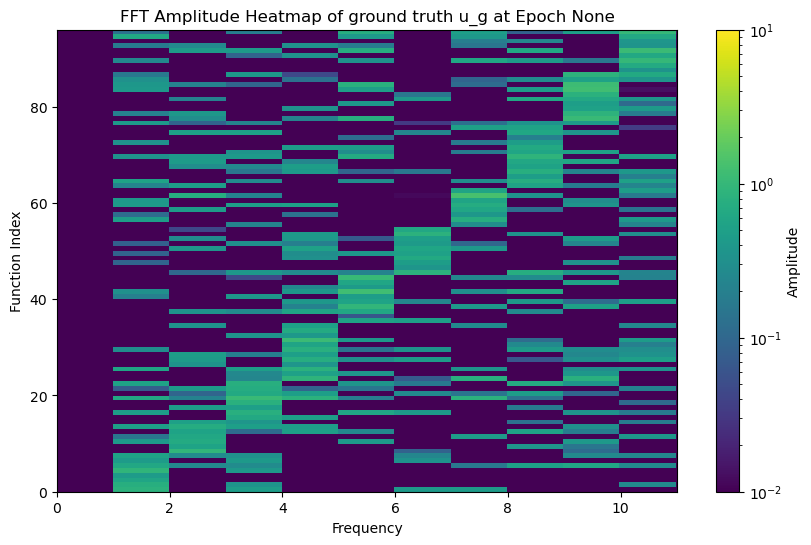

In [32]:
set_seed(seed)
L3ModelK3_low = SimpleCNN(n_layers=3, kernel_size=3)
plot_heatmaps(model=L3ModelK3_low, residue='fourier of error', all=False, first=True)


**The above looks a lot like the trained model output or true derivative**

### **USE THIS for analyzing the training dynamics**

3
Plotting ground truth u_g
Plotting ground truth u_g
Sorting u_g for the first time
Epoch [1/300], Train Loss: 67.7814, Test Loss: 74.7130
Plotting the colormap once at iteration 0
Plotting $u_g'$
Using predefined sort


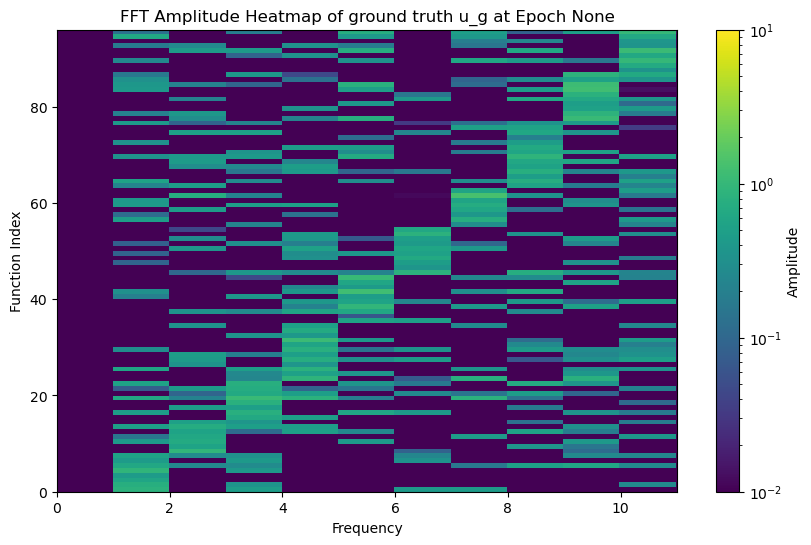

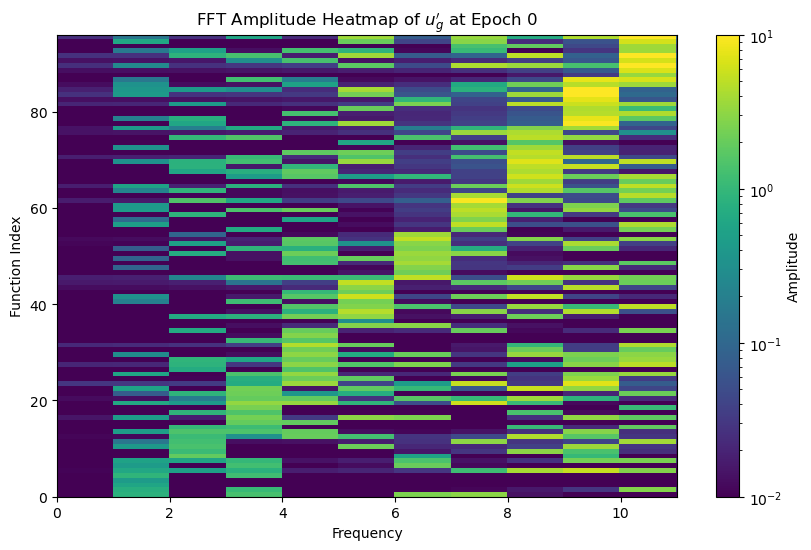

KeyboardInterrupt: 

In [33]:
set_seed(seed)
L3ModelK3_low = SimpleCNN(n_layers=3, kernel_size=3)
# residue_type = 'error of fourier'
residue_type = None

nmse = False
deriv = True

train_losses, test_losses, *_ = model_training_plots(L3ModelK3_low, train_dataloader_g, test_dataloader_g,\
    num_epochs=300, split_freq=100, filename='../plots/spectral_bias/f0_E2000_phased_training',\
    save=save, order='first', deriv=deriv, residue=residue_type, lr=1e-4, nmse=nmse)
plot_losses(train_losses, test_losses, save_dir='../plots/spectral_bias', filename='f0_E2000_phased_training', save=save)

In [ ]:
def train_multiple_runs(train_dataloader, test_dataloader, num_epochs, random_seeds, **kwargs):
    overall_low_freq_nmses = []
    overall_general_freq_nmses = []
    overall_high_freq_nmses = []
    
    for seed in random_seeds:
        torch.manual_seed(seed)
        np.random.seed(seed)

        set_seed(seed)
        model = SimpleCNN(n_layers=3, kernel_size=3)

        
        train_losses, test_losses, low_freq_nmses, general_freq_nmses, high_freq_nmses, epoch_list = model_training_plots(
            model, train_dataloader, test_dataloader, num_epochs, **kwargs
        )
        
        overall_low_freq_nmses.append(low_freq_nmses)
        overall_general_freq_nmses.append(general_freq_nmses)
        overall_high_freq_nmses.append(high_freq_nmses)
    
    return overall_low_freq_nmses, overall_general_freq_nmses, overall_high_freq_nmses, epoch_list

In [ ]:
def plot_results_with_error_bars(overall_low_freq_nmses, overall_general_freq_nmses,\
    overall_high_freq_nmses, epoch_list, fig_path):
    plt.figure(figsize=(10, 6))
    
    for data, label in zip([overall_low_freq_nmses, overall_general_freq_nmses, overall_high_freq_nmses], 
                           ['Low freq NMSE', 'General freq NMSE', 'High freq NMSE']):
        mean_losses = np.mean(data, axis=0)
        std_losses = np.std(data, axis=0)
        
        plt.plot(epoch_list, mean_losses, label=f'Mean {label}')
        plt.fill_between(epoch_list, mean_losses - std_losses, mean_losses + std_losses, alpha=0.2)

    plt.xlabel('Epoch')
    plt.ylabel('NMSE')
    plt.yscale('log')
    plt.title('Mean NMSEs of different frequencies during training (with std dev)')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.savefig(fig_path)
    

In [ ]:
# random_seeds = [1, 2, 3, 4, 5]
random_seeds = [1, 2]
num_epochs = 20

overall_low_freq_nmses, overall_general_freq_nmses, overall_high_freq_nmses,\
    epoch_list = train_multiple_runs(train_dataloader_g, test_dataloader_g, num_epochs, random_seeds)

# Plot the results
plot_results_with_error_bars(overall_low_freq_nmses, overall_general_freq_nmses,\
    overall_high_freq_nmses, epoch_list, fig_path='/home/users/erikwang/multistage/plots/spectral_bias/L3K3_MSE_runs.png')